In [116]:
import os
import json
#import torch
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from numpy.linalg import inv
import tensorflow as tf
import glob
import cv2

sway_folder = "/home/jovyan/data/metrabs-processed/sway"
root = f"{sway_folder}/sway61769"

### Get all video folder names. Don't us os.listdir(root) because it is too slow
with open(f"{sway_folder}/dataset61769.txt", "r") as f:
    vidnames = [line.strip() for line in f.readlines()]

In [117]:
##### IMPORTANT! This is the joint order information!!! It follows human3.6m
joint_names = np.array(['pelv', 'rhip', 'rkne', 'rank', 'lhip', 'lkne', 'lank', 'spin', 'neck', 'head', 'htop', 'lsho', 'lelb', 'lwri', 'rsho', 'relb', 'rwri'])
joint_edges = np.array([ [ 9, 10],
                         [ 9,  8],
                         [ 6,  5],
                         [12, 11],
                         [12, 13],
                         [ 4,  5],
                         [ 4,  0],
                         [11,  8],
                         [ 8, 14],
                         [ 8,  7],
                         [ 0,  1],
                         [ 0,  7],
                         [ 3,  2],
                         [15, 14],
                         [15, 16],
                         [ 1,  2]])

In [118]:
def visualize(image, keypoint_2d, pose3d, bbox=None, _keypoint_2d=None):
    h, w, _ = image.shape
    plt.clf()
    fig = plt.figure(figsize=(16, 5))
    image_ax = fig.add_subplot(1, 4, 1)
    image_ax.imshow(image)
    
#     for j in range(keypoint_2d.shape[0]):
#         image_ax.plot(keypoint_2d[j, 0], keypoint_2d[j, 1], "o", markersize=3, color="orange")
    
    for jj, (i_start, i_end) in enumerate(joint_edges):
        image_ax.plot(*zip(keypoint_2d[i_start], keypoint_2d[i_end]), marker='o', markersize=2)
    image_ax.scatter(*keypoint_2d.T, s=3)
    
    if _keypoint_2d is not None:
        for joint2d in _keypoint_2d:
            x = joint2d['u'] * w
            y = joint2d['v'] * h
            image_ax.plot(x, y, "o", markersize=3, color="white", alpha=joint2d['confidence'])
        
    if bbox is not None:
        min_x = bbox[0]
        min_y = bbox[1]
        max_x = bbox[0] + bbox[2]
        max_y = bbox[1] + bbox[3]
        image_ax.plot([min_x, max_x, max_x, min_x, min_x], [min_y, min_y, max_y, max_y, min_y])

    deg = 5
    views = [(deg, deg - 90), (deg, deg), (90 - deg, deg - 90)]
    _pose3d = pose3d.copy()
    _pose3d[..., 1], _pose3d[..., 2] = _pose3d[..., 2], - _pose3d[..., 1]
    for vv, view in enumerate(views):
        pose_ax = fig.add_subplot(1, 4, vv + 2, projection='3d')
        pose_ax.view_init(*view)
        pose_ax.set_xlim3d(-1000, 1000)
        pose_ax.set_zlim3d(-1000, 1000)
        pose_ax.set_ylim3d(800, 3000)
        
        for jj, (i_start, i_end) in enumerate(joint_edges):
            pose_ax.plot(*zip(_pose3d[i_start], _pose3d[i_end]), marker='o', markersize=2)
        pose_ax.scatter(*_pose3d.T, s=2)
    plt.show()
    return

In [119]:
#### Currently only support the first couple of videos. Will let you know the preprocessing progress!!!
# vidname = np.random.choice(vidnames)
vidname = vidnames[200]

## Video directory
folderpath = os.path.join(root, vidname)
imagefiles = [f for f in sorted(os.listdir(os.path.join(root, vidname, "images"))) if f.endswith(".jpg")]
imagefiles = imagefiles[::5]

## Use the 'imagefilename' as key to get the annotations from npy dictionaries. Sometimes the key does not exist because the bounding box is not detected. Make sure you handle the case.
frame_id = np.random.randint(0, len(imagefiles))
imagefile = imagefiles[frame_id]
imagefilename = imagefile.replace('.jpg', '')

## Metrab annotation directory:
metrab_dir = os.path.join(root, vidname, "metrab_annotations")
print(vidname, frame_id, imagefilename)

00096ed0-3f31-4996-b2a2-4d23f8bcc0a4 13 00066


In [120]:
##### Load the npy files as dictionary
poses3d_path = os.path.join(metrab_dir, "poses3d.npy")
poses2d_path = os.path.join(metrab_dir, "poses2d.npy")
bbox_path = os.path.join(metrab_dir, "bbox.npy")
intrinsics_path = os.path.join(metrab_dir, "intrinsics.npy")
extrinsics_path = os.path.join(metrab_dir, "extrinsics.npy")

pose3d_seq = np.load(poses3d_path, allow_pickle=True).item() 
pose2d_seq = np.load(poses2d_path, allow_pickle=True).item()
bbox_seq = np.load(bbox_path, allow_pickle=True).item()
intrinsics = np.load(intrinsics_path)
extrinsics = np.load(extrinsics_path) ### Always a 4x4 identity matrix !!! So camera-space pose is always the same as world-space pose

Max pixel joint difference: 0.3984727346602881
bounding box: [281.5511     302.71893    269.341      345.95715      0.99445987]
shape of pose3d: (17, 3)
shape of pose2d: (17, 2)


<Figure size 432x288 with 0 Axes>

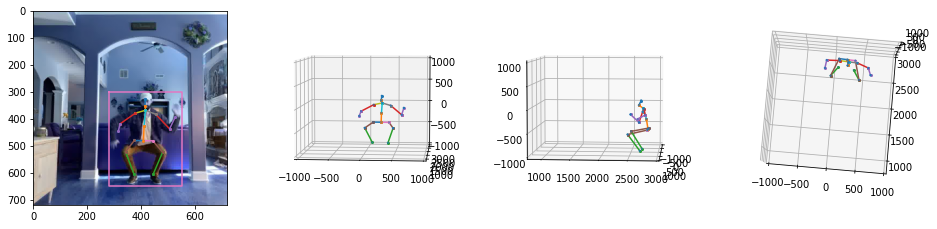

In [121]:
bbox = bbox_seq.get(imagefilename)
pose3d = pose3d_seq.get(imagefilename)
pose2d = pose2d_seq.get(imagefilename)

### Check if pose2d has huge difference from reprojected_pose2d
homo_pose3d = pose3d / pose3d[..., -1:]
reprojected_pose2d = homo_pose3d @ intrinsics[:2].T
print("Max pixel joint difference:", np.max(np.abs(reprojected_pose2d - pose2d)))

if bbox is not None: # this means annotation is found!
    print("bounding box:", bbox)
    print("shape of pose3d:", pose3d.shape)
    print("shape of pose2d:", pose2d.shape)
    image_path = os.path.join(root, vidname, "images", imagefile)
    image = cv2.imread(image_path)
    visualize(image, pose2d, pose3d, bbox)
